# Relaxation of 2 daughter cells after proliferation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance

dim = 1
seed = 67

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 0.0001 

params = {'EF_glob_adap_acc': {'eta': eta},
#          'EF_glob_adap_stab': {'eta': eta, 'calculate_eigenvalues': True, 'write_to_file': True, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_glob_adap_stab': {'eta': eta, 'write_to_file': True, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_local_adap': {'eta': eta, 'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True, 'local_adaptivity': True, 'm0': 2}, 
          'EB_global_adap': {'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (GAFE)', 
          'EF_glob_adap_stab': 'Alg. II (GAFES)' ,  
          'EF_local_adap': 'Alg. III (LAFE)', 
          'EB_global_adap': 'Alg. IV (GABE)'
         }

## Time step sizes as a function of chosen absolute error

In [4]:
cell_list = [cl.Cell(0, [0]), cl.Cell(1, [0.3])]

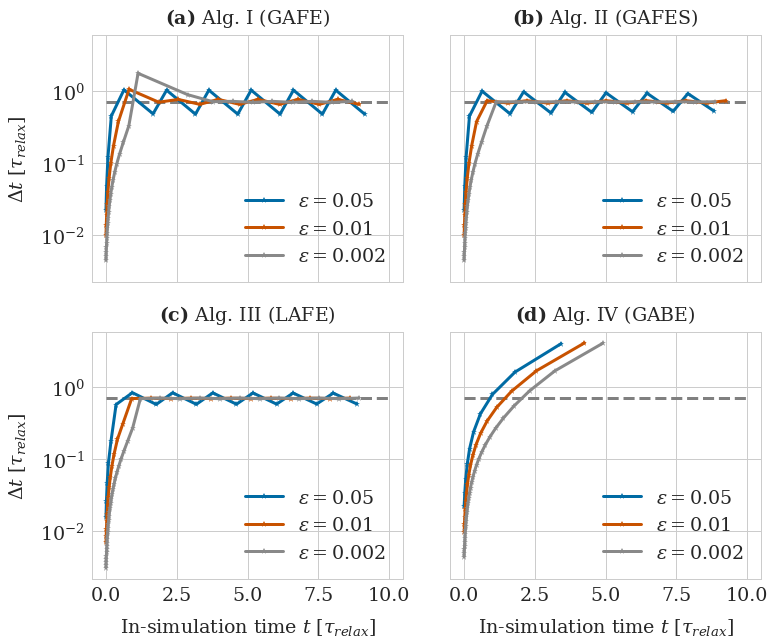

In [5]:
    
try:
    os.remove('step_sizes.txt')
except FileNotFoundError:
    print('Nothing to delete.')

colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

epsilons = [0.05, 0.01, 0.002]

gp_cubic = params_cubic['mu']*(s-rA)**2
      
for alg in algorithms:
    
    axes[alg].plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color='grey' )
    
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (GAFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (GAFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (LAFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (GABE)')
    
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax3.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')    
ax3.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')

plt.savefig('2cells_dt.pdf', bbox_inches='tight')

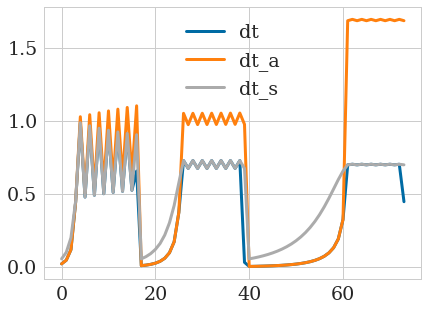

In [6]:
dts = np.loadtxt('step_sizes.txt')

plt.plot( dts[:, 0], label='dt')
plt.plot( dts[:, 1], label='dt_a')
plt.plot( dts[:, 2], label='dt_s')
plt.legend()

Note that these are the dt_s for all three epsilon values in one graph, side by side. that means the first part is for eps=0.05, once the step size restarts at 0 it's for eps=0.01 and when it restarts again it;s for eps=0.002. The problem is hence that for larger eps the calculated stability bound is less accurate and oscillates. This is independent of whether gershgorin is used or not.

The reason that dt_a reaches a plateau and does not increase further is due to the system being solved with the dt_s and hence reaching a steady state such that nothing changes further.

## Convergence study
We do the convergence study in 1D for convenience.

dim = 1
models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }
eta = 0.0001 
# redefine the parameters due to the Jacobian
params = {'EF_glob_adap_acc': {'eta': eta},
          'EF_glob_adap_stab': {'eta': eta, 'calculate_eigenvalues': True, 'write_to_file': True, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_local_adap': {'eta': eta, 'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True, 'local_adaptivity': True, 'm0': 4, 'm1': 1}, 
          'EB_global_adap': {'eta': eta}
         }

In [7]:
cell_list = [cl.Cell(0, [0]), cl.Cell(1, [0.3])]

In [8]:
# calculate reference solution
dt_ref = 0.00005
tf = 3.0
#N_ref = int(1/dt_ref*tf)+1

cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)

ts_ref, history = cbmodel.simulate(cell_list, [0, tf], params_cubic, {'dt': dt_ref}, seed=seed)

ref_traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N_ref, n_cells, dim)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

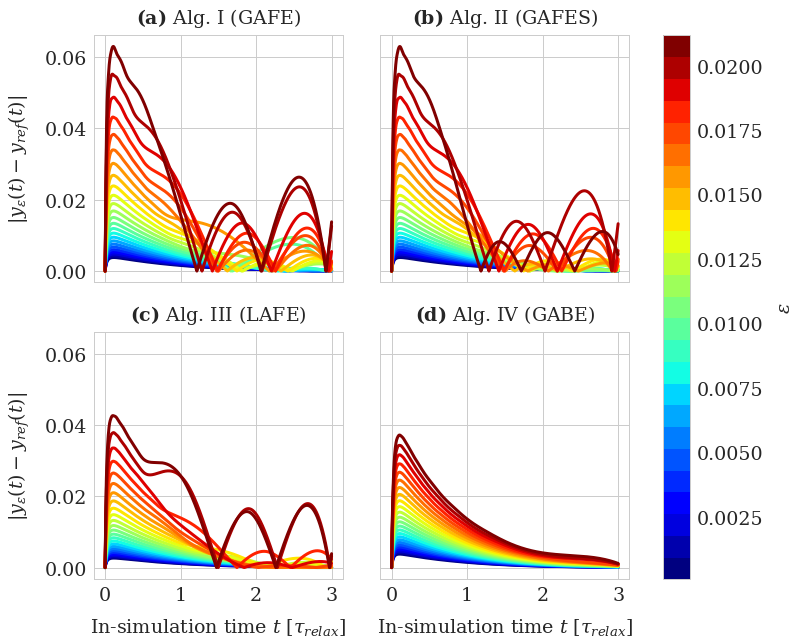

In [9]:
# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

r = 25
eps_values = np.array([0.0001*1.25**n for n in range(0, r)])
map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, r))))/(np.max(range(0, r))-np.min(range(0, r)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]

sol = {}
for alg in algorithms:
    
    for i, eps in enumerate(eps_values):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, [0, tf], params_cubic, params[alg], seed=seed)
        
        traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)
        
        interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, 
                              kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ts_ref[:])
        
        error = (np.linalg.norm(interp - ref_traj, ord=np.inf, axis=0)/np.linalg.norm(ref_traj, ord=np.inf, axis=0)).mean(axis=0)
        sol.setdefault(alg, []).append(error)
        
        axes[alg].plot(ts_ref, np.abs((interp[:, 1, 0] - interp[:, 0, 0])  - (ref_traj[:, 1, 0] - ref_traj[:, 0, 0])), color=colors[i])

        
#    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (GAFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (GAFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (LAFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (GABE)')
    
ax1.set(ylabel=r'$|y_{\epsilon}(t)-y_{ref}(t)|$')
ax3.set(ylabel=r'$|y_{\epsilon}(t)-y_{ref}(t)|$')    
ax3.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')

cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = fig.colorbar(msm, ax=[ax1, ax2, ax3, ax4])
cbar.set_label('$\epsilon$', rotation=90)

plt.savefig('2cells_errors.pdf', bbox_inches='tight')

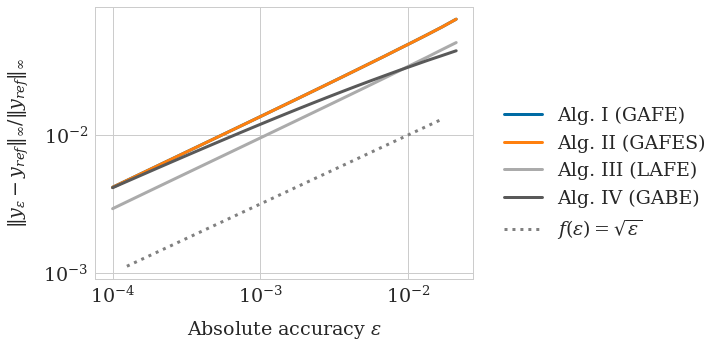

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))
for alg in algorithms:
    ax.loglog(eps_values, sol[alg], '-', label=labels[alg])

ax.loglog(eps_values[1:-1], eps_values[1:-1]**0.5*0.1, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
ax.set(xlabel='Absolute accuracy $\epsilon$')
ax.set(ylabel='$\Vert y_{\epsilon}-y_{ref}\Vert_{\infty}/\Vert y_{ref}\Vert_{\infty}$')
fig.legend(loc=7)
fig.subplots_adjust(right=0.65)  
#plt.grid(True)
plt.savefig('2cells_order.pdf', bbox_inches='tight')

Could be that the iterations in EB are not fully converged and it loses the order of convergence due to that. Check. 

In [11]:
eps_values

array([0.0001    , 0.000125  , 0.00015625, 0.00019531, 0.00024414,
       0.00030518, 0.00038147, 0.00047684, 0.00059605, 0.00074506,
       0.00093132, 0.00116415, 0.00145519, 0.00181899, 0.00227374,
       0.00284217, 0.00355271, 0.00444089, 0.00555112, 0.00693889,
       0.00867362, 0.01084202, 0.01355253, 0.01694066, 0.02117582])